In [1]:
import pandas as pd
import nltk
import sklearn
import textblob
from textblob import TextBlob
import matplotlib
import numpy as np
import seaborn as sns
import re

In [2]:
dataset=pd.read_csv("D:/psychatric symptom detection data/tweetss.csv",encoding="latin-1")

In [3]:
dataset.head()

,tweets,Sex,symptom,type,Level
0,Do You Think You Might Be Going Insane Again?,1,1,1,Severe
1,The Day My Heart Broke  Part Two,1,1,3,Severe
2,New #blog post alert! I discuss depression and...,1,1,3,Severe
3,Bipolar Disorder  My Super Power,1,1,2,Severe
4,Finally its Christmas drink season @starbucks...,1,0,0,None


In [4]:
dataset['tweets']=dataset.tweets.astype(str)

In [5]:
dataset['polarity']=dataset['tweets'].apply(lambda tweet:TextBlob(tweet).sentiment.polarity)

In [6]:
dataset['subjectivity']=dataset['tweets'].apply(lambda tweet:TextBlob(tweet).sentiment.subjectivity)


In [7]:
dataset.head()

,tweets,Sex,symptom,type,Level,polarity,subjectivity
0,Do You Think You Might Be Going Insane Again?,1,1,1,Severe,-1.000000,1.000000
1,The Day My Heart Broke  Part Two,1,1,3,Severe,0.000000,0.000000
2,New #blog post alert! I discuss depression and...,1,1,3,Severe,-0.132792,0.622078
3,Bipolar Disorder  My Super Power,1,1,2,Severe,0.333333,0.666667
4,Finally its Christmas drink season @starbucks...,1,0,0,None,0.000000,1.000000


In [8]:
#import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
matplotlib.style.use('ggplot')
from subprocess import check_output
from nltk.tokenize import ToktokTokenizer
toktok=ToktokTokenizer()

In [9]:
### Split Dataset into Train and Text
from sklearn.model_selection import train_test_split
# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
df=dataset
df.head()
df.tail()

,tweets,Sex,symptom,type,Level,polarity,subjectivity
3994,I guess I'm gonna travel. Just fearful (very f...,1,1,2,Severe,-0.680000,0.773333
3995,RT @halsey : No jokes right now. I have dedica...,1,1,2,Severe,0.142857,0.417857
3996,Do yourselves a favor... dont EVER date a per...,1,1,2,Severe,0.468750,0.800000
3997,"@LCNSB_ I'm sorry, because I suffer from sever...",1,1,2,Severe,-0.400000,0.638889
3998,RT @StrugglingAnon_ : Honestly I am so fucking...,1,1,2,Highly severe,0.200000,0.500000


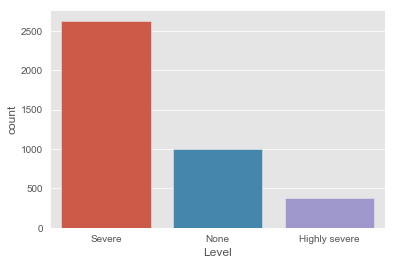

In [11]:
# Value Count 
sns.countplot(df['Level'])

In [12]:
import re
def initial_clean(tweets):
    """
    Function to clear text of websites,email addresses and any punctuation
    We also lower case the text
    """
    tweets=re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)"," ",tweets)
    tweets=re.sub("[^a-zA-Z]"," ",tweets)
    tweets=tweets.lower()
    #text=nltk.word_tokenize(text)
    tweets=toktok.tokenize(tweets)
    return tweets
#stop_words=stopwords.words('english')
'''
def remove_stop_words(tweets):
    
    Function that removes all stopwords from text
    
    return [word for word in message if word not in stop_words] '''
stemmer=PorterStemmer()
def stem_words(tweets):  
    '''
    Function to stem words so that plural and singular are treated the same
    '''
    try:
        tweets=[stemmer.stem(word) for word in tweets]
        tweets=[word for word in tweets if len(word)>1] #make sure we have no 1 letter words
    except IndexError: #the word 'oed' broke this,so needed try except
        pass
    return tweets
def apply_all(tweets):
    '''
    This function applies all the function above into one  remove_stop_words
    '''
    
    return stem_words(initial_clean(tweets))


In [13]:
#clean message and tweets and create new column 'tokenized'
import time
t1=time.time()
df['tokenized']=df['tweets'].apply(apply_all) + df['tweets'].apply(apply_all)
t2=time.time()
print("Time to clean and tokenize",len(df),"articles: ",(t2-t1)/60,"min")


Time to clean and tokenize 3999 articles:  0.4996297319730123 min


In [14]:
tokens=[]
for i in range(0,len(df)):
    k=df['tokenized'][i]
    tokens.append(k)

In [15]:
tokens[0]

['do',
 'you',
 'think',
 'you',
 'might',
 'be',
 'go',
 'insan',
 'again',
 'do',
 'you',
 'think',
 'you',
 'might',
 'be',
 'go',
 'insan',
 'again']

In [ ]:
df.dtypes

In [16]:
k=df[['Sex','polarity','subjectivity','symptom','type']].values

In [17]:
y=df[['Level']]

In [18]:
feature_size=150
window_context=10
min_word_count=2
sample=1e-3

In [19]:
from gensim.models import word2vec  
from gensim.models.word2vec import Word2Vec
w2v_model=word2vec.Word2Vec(tokens,size=feature_size,window=window_context,min_count=min_word_count,sample=sample,iter=50)
similar_words={search_term:[item[0] for item in w2v_model.wv.most_similar([search_term],topn=5)]
              for search_term in['broke','hate']}

In [20]:
similar_words

{'broke': ['girlfriend', 'philli', 'cheat', 'nail', 'fridayfun'],
 'hate': ['inch', 'corner', 'snow', 'disgust', 'annoy']}

In [21]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector=np.zeros((num_features,),dtype="float64")
    nwords=0.
    
    for word in words:
        if word in vocabulary:
            nwords=nwords+1.
            feature_vector=np.add(feature_vector,model[word])
            
    if nwords:
        feature_vector=np.divide(feature_vector, nwords)
    
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary=set(model.wv.index2word)
    features=[average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
             for tokenized_sentence in corpus]
    return np.array(features)


x=averaged_word_vectorizer(corpus=tokens, model=w2v_model, num_features=feature_size )
df=pd.DataFrame(x)

C:\Users\Merry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [22]:
print(x)

[[ 0.14612704 -0.28300166  0.58858339 ...  0.3400284  -0.83953953
   0.21606142]
 [-0.25119789 -0.80366728 -0.22372571 ...  0.11540563  0.97306336
  -0.85738084]
 [-0.2949062   0.48631806 -0.45378725 ...  0.47927814  0.17431089
   0.08439055]
 ...
 [ 0.33316859 -0.11175381  0.71281359 ...  0.35794061  0.04494485
  -0.29677935]
 [ 0.21484429 -0.39711724 -0.0404413  ...  0.28306996 -0.13456274
   0.65909113]
 [ 0.94043385  0.18984506  0.30194683 ... -0.94625929 -0.44272195
  -1.67291704]]


In [ ]:
len(df)

In [23]:
x=pd.DataFrame(np.array(x))
#k=df[['Sex','polarity','subjectivity','symptom','type']].values
p=pd.DataFrame(np.array(k))
X=pd.concat([x,p],axis=1)
#x_feature.shape
X

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,0,1,2,3,4
0,0.146127,-0.283002,0.588583,0.824381,-0.235638,0.543583,-0.284950,-0.018904,0.483489,0.343548,...,0.077690,0.351761,0.340028,-0.839540,0.216061,1.0,-1.000000,1.000000,1.0,1.0
1,-0.251198,-0.803667,-0.223726,-0.385716,-0.347435,-0.823394,0.122872,0.182749,0.481140,0.522476,...,0.020780,-0.853627,0.115406,0.973063,-0.857381,1.0,0.000000,0.000000,1.0,3.0
2,-0.294906,0.486318,-0.453787,0.025204,-0.453627,0.066094,-0.404679,-0.194382,0.199709,0.045173,...,0.024793,-0.203389,0.479278,0.174311,0.084391,1.0,-0.132792,0.622078,1.0,3.0
3,-0.464359,-0.855024,-0.422839,0.064581,-0.168386,0.437661,-0.313408,-0.691575,0.085461,-0.156305,...,0.579604,-1.399290,0.329812,0.861841,0.325947,1.0,0.333333,0.666667,1.0,2.0
4,-0.461422,0.343494,-1.074532,-0.465227,-0.746004,0.145900,0.447354,-0.370929,0.445013,-0.036236,...,-0.014875,-0.502417,0.690415,0.117246,0.220275,1.0,0.000000,1.000000,0.0,0.0
5,1.338023,0.189502,-0.247728,0.540042,-0.228106,-0.286865,-1.461772,-0.008866,-0.496192,0.887202,...,-0.021355,-0.339756,0.473270,-0.728194,1.283209,1.0,0.000000,0.000000,1.0,2.0
6,-0.127425,0.083117,-0.456859,-0.392360,-0.210621,-0.243813,0.568866,0.325105,-0.153527,-0.074565,...,0.133757,-0.085479,0.353282,0.322597,0.062109,1.0,0.400000,0.450000,1.0,2.0
7,-0.516256,-0.045893,-0.215581,-0.419814,-0.650925,-0.142405,-0.687709,-0.381899,0.143312,-0.225973,...,0.308124,-0.230921,-0.442758,0.231777,0.619365,1.0,0.000000,0.000000,1.0,1.0
8,-0.155394,-0.104250,-0.322763,-0.197628,-0.450116,-0.028498,-0.263370,0.189298,-0.333218,0.038025,...,0.240223,-0.402363,-0.036143,0.512669,0.301344,1.0,0.200000,0.300000,1.0,1.0
9,-0.449862,-0.497701,-0.606315,-0.037554,0.212688,0.285673,-0.331630,0.466610,-0.118038,-0.922182,...,0.446627,-0.892329,0.878451,-0.194486,0.390098,1.0,0.000000,0.000000,1.0,2.0


In [ ]:
y=df[['Level']]
y=pd.dataframe(np.array(y))
#df.columns

In [24]:
from imblearn.over_sampling import SMOTE

C:\Users\Merry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Merry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Merry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

In [25]:
# Split Data 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [26]:
X.shape,y.shape
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((3199, 155), (3199, 1), (800, 155), (800, 1))

In [27]:
oversample = SMOTE(random_state=42)
X_train,y_train=oversample.fit_resample(X_train,y_train)

C:\Users\Merry\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Merry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Merry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [28]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((6381, 155), (6381,), (800, 155), (800, 1))

In [29]:
from collections import Counter
counter=Counter(y_train)
for k,v in counter.items():
    dist=v/len(y_train)*100
    print(f"class={k},n={v},({dist}%)")

class=None,n=2127,(33.33333333333333%)
class=Severe,n=2127,(33.33333333333333%)
class=Highly severe,n=2127,(33.33333333333333%)


In [30]:
# ML Pkgs
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB


In [31]:
from sklearn import metrics
import numpy as np
import itertools

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Number of documents = 6381  |  Number of features = 155
Accuracy of LogisticRegression  classifier on training set: 0.97
Accuracy of LogisticRegression classifier on test set: 0.95
accuracy:   0.949
Confusion matrix, without normalization


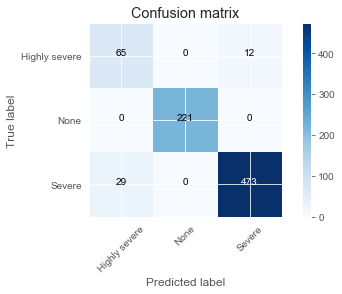

In [33]:
from sklearn.linear_model import  LogisticRegression
logreg=LogisticRegression(C=1e5, max_iter=10000 )
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Accuracy of LogisticRegression  classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of LogisticRegression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Highly severe', 'None','Severe'])

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

Highly severe       0.69      0.84      0.76        77
         None       1.00      1.00      1.00       221
       Severe       0.98      0.94      0.96       502

     accuracy                           0.95       800
    macro avg       0.89      0.93      0.91       800
 weighted avg       0.95      0.95      0.95       800



Accuracy of support vector machine   classifier on training set: 0.96
Accuracy of support vector machine classifier on test set: 0.96
accuracy:   0.958
Confusion matrix, without normalization


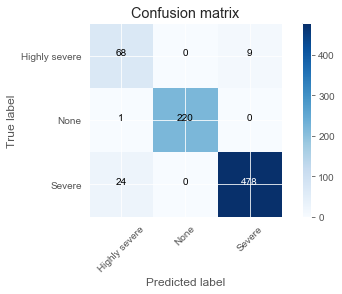

In [35]:
from sklearn.svm import LinearSVC
svmmodel_w2v= LinearSVC(C=0.01, multi_class='ovr', max_iter=10000, 
                        class_weight='balanced',penalty='l2' )
svmmodel_w2v=svmmodel_w2v.fit(X_train, y_train)
pred = svmmodel_w2v.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Accuracy of support vector machine   classifier on training set: {:.2f}'
     .format(svmmodel_w2v.score(X_train, y_train)))
print('Accuracy of support vector machine classifier on test set: {:.2f}'
     .format(svmmodel_w2v.score(X_test, y_test)))
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Highly severe', 'None','Severe'])

In [36]:
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

Highly severe       0.73      0.88      0.80        77
         None       1.00      1.00      1.00       221
       Severe       0.98      0.95      0.97       502

     accuracy                           0.96       800
    macro avg       0.90      0.94      0.92       800
 weighted avg       0.96      0.96      0.96       800



Accuracy of RandomForest  classifier on training set: 1.00
Accuracy of RandomForest classifier on test set: 0.95
accuracy:   0.955
Confusion matrix, without normalization


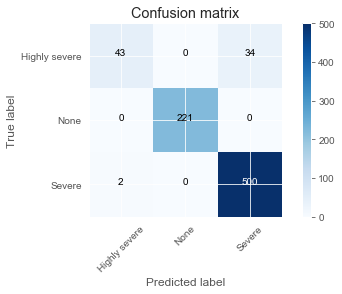

In [37]:
from sklearn.ensemble import RandomForestClassifier
Random=RandomForestClassifier(n_estimators=400, n_jobs=4)
Random.fit(X_train, y_train)
pred = Random.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Accuracy of RandomForest  classifier on training set: {:.2f}'
     .format(Random.score(X_train, y_train)))
print('Accuracy of RandomForest classifier on test set: {:.2f}'
     .format(Random.score(X_test, y_test)))
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)

plot_confusion_matrix(cm, classes=['Highly severe', 'None','Severe'])

In [38]:
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

Highly severe       0.96      0.56      0.70        77
         None       1.00      1.00      1.00       221
       Severe       0.94      1.00      0.97       502

     accuracy                           0.95       800
    macro avg       0.96      0.85      0.89       800
 weighted avg       0.96      0.95      0.95       800



Number of documents = 6381  |  Number of features = 155
Total time: 0.18s
accuracy: 0.955
0.955
Confusion matrix, without normalization


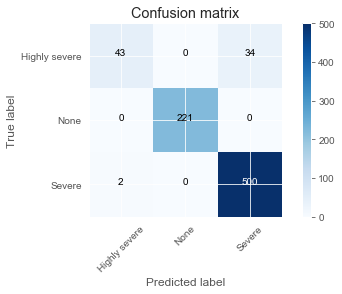

In [39]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
nb_model = GaussianNB()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
#predictions, accuracy, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
nb_model.fit(X_train,y_train)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
score = metrics.accuracy_score(y_test, pred)
print('accuracy: {}'.format(score))
print('='*100)
print(score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,classes=['Highly severe', 'None','Severe'])

In [40]:
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

Highly severe       0.96      0.56      0.70        77
         None       1.00      1.00      1.00       221
       Severe       0.94      1.00      0.97       502

     accuracy                           0.95       800
    macro avg       0.96      0.85      0.89       800
 weighted avg       0.96      0.95      0.95       800

